In [1]:
%%HTML
<style> code {margin: 0 2px !important;
  padding: 0 5px !important;
  white-space: nowrap !important;
  border: 1px solid #eaeaea !important;
  background-color: #f8f8f8 !important;
  border-radius: 3px !important;} </style>

In [2]:
%load_ext watermark
%watermark -a 'lorenzo Perozzi' -d -m -v -p pandas,seaborn,sklearn

lorenzo Perozzi 2017-08-22 

CPython 3.5.2
IPython 5.1.0

pandas 0.20.2
seaborn 0.7.1
sklearn 0.19.0

compiler   : GCC 4.4.7 20120313 (Red Hat 4.4.7-1)
system     : Linux
release    : 3.10.0-514.21.1.el7.x86_64
machine    : x86_64
processor  : x86_64
CPU cores  : 32
interpreter: 64bit


# Table of contents
- [Loading the database](#Loadiing-the-database)
- [Oversampling the minority class](#Oversampling-the-minority-class)
- [Feature importance](#Feature-importance)
- [Tree graph](#Tree-graph)
- [Open questions](#Open-questions)

## Loading the database
~~The database is split into training and testing, in order to train the model on rockbursts `<=` 2014 and test the model on rockbursts `>` 2014.
We end-up with 24 rockburst in the training set and 10 in the testing set.~~

In [3]:
# from tpot import TPOTClassifier
from sklearn.cross_validation import LeaveOneOut
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('white')
import pandas as pd
import numpy as np
from sklearn.tree import export_graphviz
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.utils import resample

from sklearn.metrics import auc, roc_curve
from sklearn.model_selection import StratifiedKFold
from imblearn.over_sampling import ADASYN, SMOTE, RandomOverSampler
from imblearn.pipeline import make_pipeline
from scipy import interp


import warnings
warnings.filterwarnings('ignore')

/usr/local/anaconda3/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [4]:
ml_database = pd.read_csv('data/dataset_ML/ml_database.csv')

train = ml_database[ml_database['snapshot'] <= 15]
test = ml_database[ml_database['snapshot'] > 15]
train.drop('snapshot', axis=1, inplace=True)
test.drop('snapshot', axis=1, inplace=True)
train['Rockburst'].value_counts()

X_train = train.drop('Rockburst', axis=1).values
y_train = train.loc[:,'Rockburst'].values


### Oversampling the minority class + ROC curve
Since the dataset is hugely unbalanced, few techniques to oversample the minority class are compared. Specifically, a `random over sampler` and the `SMOTE` are used. It is important to apply the oversampling before the cross-validation step, otherwise it can result in an overfitting  problem. 

Automatically created module for IPython interactive environment


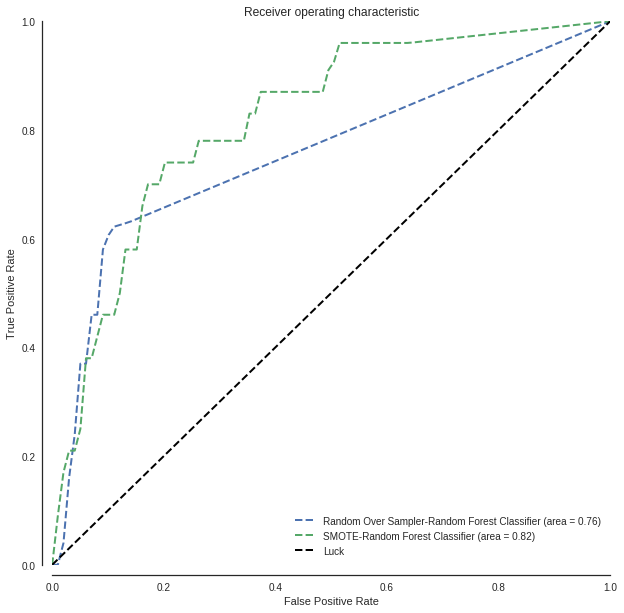

In [5]:
print(__doc__)

LW = 2
RANDOM_STATE = 42
min_samples_leaf=100
cv = StratifiedKFold(n_splits=5)


classifier = ['Random Forest Classifier', RandomForestClassifier(n_estimators=100,min_samples_leaf=min_samples_leaf, 
                                                      bootstrap=False, n_jobs=-1)]
# classifier = ['Gradient Boosting', GradientBoostingClassifier(n_estimators=100,min_samples_leaf=min_samples_leaf, 
#                                                       max_depth=10)]
samplers = [
#     ['ADASYN', ADASYN(random_state=RANDOM_STATE)],
    ['Random Over Sampler', RandomOverSampler(random_state=RANDOM_STATE)],
    ['SMOTE', SMOTE(random_state=RANDOM_STATE)],
]

pipelines = [
    ['{}-{}'.format(sampler[0], classifier[0]),
     make_pipeline(sampler[1], classifier[1])]
    for sampler in samplers
]

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1, 1, 1)

for name, pipeline in pipelines:
    mean_tpr = 0.0
    mean_fpr = np.linspace(0, 1, 100)
    for train, test in cv.split(X_train, y_train):
        probas_ = pipeline.fit(X_train[train], y_train[train]).predict_proba(X_train[test])
        fpr, tpr, thresholds = roc_curve(y_train[test], probas_[:, 1])
        mean_tpr += interp(mean_fpr, fpr, tpr)
        mean_tpr[0] = 0.0
        roc_auc = auc(fpr, tpr)

    mean_tpr /= cv.get_n_splits(X_train, y_train)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    plt.plot(mean_fpr, mean_tpr, linestyle='--',
             label='{} (area = %0.2f)'.format(name) % mean_auc, lw=LW)

plt.plot([0, 1], [0, 1], linestyle='--', lw=LW, color='k',
         label='Luck')

# make nice plotting
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.get_xaxis().tick_bottom()
ax.get_yaxis().tick_left()
ax.spines['left'].set_position(('outward', 10))
ax.spines['bottom'].set_position(('outward', 10))
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')

plt.legend(loc="lower right")

plt.show()

### Feature importance
Ensembles methods like Random Forests are particularly interesting since they are able to output the contribution of each feature on the model, e.g.: how often each feature contribute at each node split - called also feature importance. The codes `_e`, `_b`, `_n`, `_u`, `_a` refers to the event type.

In [6]:
print('\nFEATURE IMPORTANCE RANK LIST\n')
feat_labels = ml_database.columns[1:]
importances = pipeline.steps[1][1].feature_importances_
indices = np.argsort(importances)[::-1]
for f in range(X_train.shape[1]):
    print("{0:2d}) {1:40} {2:f}".format(f+1, feat_labels[indices[f]], importances[indices[f]]))


FEATURE IMPORTANCE RANK LIST

 1) dist_e                                   0.235968
 2) density_e_25                             0.098439
 3) density_a_100                            0.074786
 4) density_u_100                            0.041625
 5) dist_a                                   0.035710
 6) density_a_250                            0.034134
 7) density_e_50                             0.029835
 8) density_b_250                            0.029694
 9) density_e_250                            0.028849
10) density_u_50                             0.027974
11) density_e_100                            0.023925
12) dist_Contact_from_glencore_part1         0.022846
13) dist_u                                   0.022316
14) dist_footwall_from_glencore              0.022153
15) Y                                        0.018291
16) density_n_250                            0.017871
17) dist_ct2                                 0.016371
18) density_u_250                            0.0160

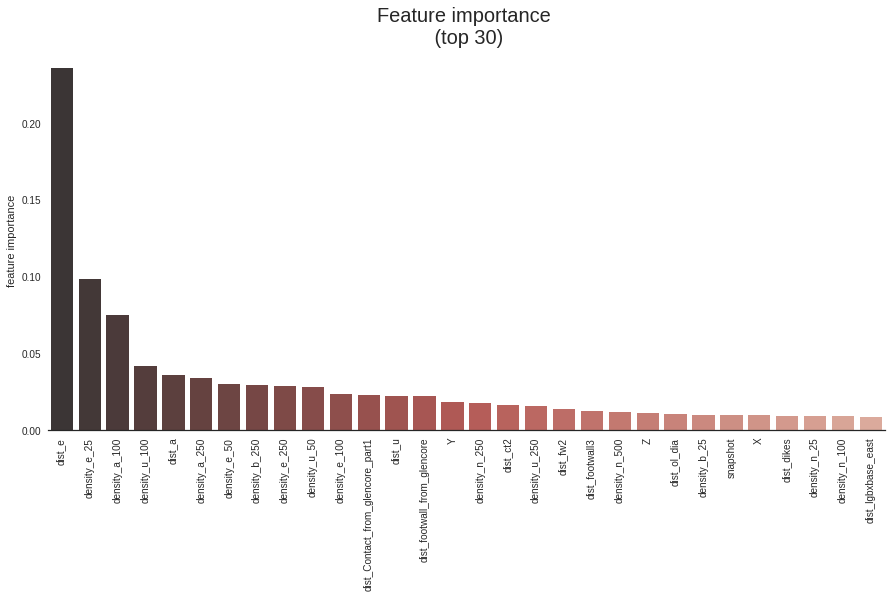

In [10]:
FeatImp = pd.DataFrame(importances[indices], columns=['importance'])
FeatImp['labels'] = feat_labels[indices]
fig, ax = plt.subplots(figsize=(15,7))
im = sns.barplot('labels', y='importance', data=FeatImp[:30],
                  palette="Reds_d", saturation=.5, ax=ax)
for item in im.get_xticklabels():
    item.set_rotation(90)
im.set(xlabel='', ylabel='feature importance')
im.set_title('Feature importance \n (top 30)', fontsize=20)
sns.despine(left=True)

### Tree graph
Next image shows a decision tree representation among the 100 used in the model.

In [11]:
dotfile = open("img/tree_232.dot", 'w')
export_graphviz(pipeline.steps[1][1].estimators_[23], 
                out_file = dotfile, 
                feature_names = ml_database[ml_database['snapshot'] <= 15].drop(['Rockburst','snapshot'], axis=1).columns,
                rounded=True,
                max_depth = 4,
                label='all')
dotfile.close()
# system("dot -Tpng .dot -o tree.png")

In [12]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(url= "img/tree_232.png")

### Open questions

- There are other options to predict the rockbursts? For example, predicting a time window before the rockburst happens (hours or days or week). However, for this specific case our time window is set to month, that is the excavation time step, maybe too much? 
- How to integrate microseimic properties: the closest to the tunnel? Microseismic property clusters over a window time (month) and take the barycenter? Work in progress...
- Using ROC curve could be useful to set an optimal `predict_proba` threshold that maximizes the `true positive rate` and minimize the `false positive rate`
- How to compare with the old dataset `NRS_2013 targeting dump`? In this data set there are more than 4000 `FOG`events. How they have been computed? Oversampling? If yes, which methods?